In [2]:
# 必要なモジュールをインポート
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

# 環境変数の読み込み
load_dotenv("../.env")
os.environ['OPENAI_API_KEY'] = os.environ['API_KEY']

# モデル名
MODEL_NAME = "gpt-4o-mini"

In [3]:
# 検索ツールの定義
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

In [4]:
tool.invoke("Langgraphのノードとは？")

[{'url': 'https://note.com/life_to_ai/n/nfbc581718912',
  'content': 'LangGraphを使えば、ノードを順に実行しながら状態を更新していくことで、まるでストーリーを語るようにエージェントが動きます。📖それでは、基礎からしっかりと学んでいきましょう。\n\n### 2. 🔠 LangGraphの基本構成\n\nLangGraphには3つの重要な構成要素があります。それぞれを理解することが、AIエージェントの作成に欠かせません。\n\nノード（Node）\n\nノードとは、Pythonの関数そのものです。💻 典型的なPythonの関数がノードの役割を果たします。 例えば、以下のように各ノードは、グラフの状態（State）を受け取り、それに対して操作を行います。 [...] それでは、実際にシンプルなグラフを構築してみましょう。\n\nノードの作成\n\nまず、エージェントに必要な機能を定義したノードを作成します。 ノードは基本的にPythonの関数であり、それぞれがグラフの一部を担います。\n\n`def node_01(state: State):\nprint(f"node_01: {state[\'graph_msg\']}")\nreturn {"graph_msg": state["graph_msg"] + " node_01"}`\n\n上記のように、ノードは状態に対して何らかの操作を行い、その結果を返します。状態が更新されることで、エージェントは次のノードでの処理を続けることができます。\n\n状態の構築\n\n次に、状態（State）を定義し、各ノードがどのように状態を変更するかを考えます。 状態には、エージェントの実行中に必要な情報がすべて含まれています。\n\n`from typing import TypedDict\nclass State(TypedDict):\ngraph_msg: str` [...] `# ノードの例\ndef node_01(state: State):\nprint(f"node_01: {state[\'graph_msg\']}")\nreturn {"graph_msg": state["graph_msg"] + "node_01"}\

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

# Stateクラスの定義
class State(TypedDict):
    messages: Annotated[list, add_messages]

# グラフのインスタンスを作成
graph_builder = StateGraph(State)

# 言語モデルの定義
llm = ChatOpenAI(model_name=MODEL_NAME)

# 変更点：ツール定義の紐づけ
llm_with_tools = llm.bind_tools(tools)

# チャットボットノードの作成
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# グラフにチャットボットノードを追加
graph_builder.add_node("chatbot", chatbot)

In [6]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# ツールノードの作成
tool_node = ToolNode(tools)

# グラフにツールノードを追加
graph_builder.add_node("tools", tool_node)

# 条件付エッジの作成
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition, # ツール呼出と判断したらツールノードを呼ぶ
)

# ツールが呼び出されるたびに、チャットボットに戻って次のステップを決定
# ツールからチャットボットへの戻りエッジを作成
graph_builder.add_edge("tools", "chatbot")

# 開始ノードの指定
graph_builder.set_entry_point("chatbot")

# 記憶を持つ実行可能なステートグラフの作成
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

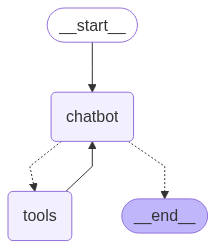

In [7]:
# グラフの可視化
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# グラフの実行と結果の表示
def stream_graph_updates(user_input: str):
    events = graph.stream(
        {"messages": [("user", user_input)]},
        {"configurable": {"thread_id": "1"}},
        stream_mode="values")
    # 結果をストリーミングで得る
    for event in events:
        print(event["messages"][-1].content, flush=True)

# チャットボットのループ
while True:
    user_input = input("質問:")
    if user_input.strip()=="":
        print("ありがとうございました!")
        break
    stream_graph_updates(user_input)

こんにちは！
こんにちは！今日はどんなことをお手伝いできますか？
1足す2は？
1足す2は3です。何か他に知りたいことがありますか？
1メートル以上の魚は？

[{"url": "https://www.nacsj.or.jp/2022/09/31920/", "content": "サーフゾーンに現れる魚の大きさは，生まれたての数ミリ程度のものから1 mを越えるものまで様々です。例えば，吹上浜で26 m型の地曳網で採集された52,946個体のうち全長49 mm以下の個体は46.3％，50〜99 mmは41.5％，100〜199 mmは10.7％，200〜299 mmは1.3％，300 mm以上は0.2％でした（須田データ）。個体数はごくわずかですが500 mmを超える個体（アカエイ，ダツ，ハマダツ，スズキ）も採集され，最大はアカエイの1,200 mmでした。これまでの研究の多くが比較的小型の器具を使ったものだったため，サーフゾーンには大型魚が出現しないという誤解が専門家の間にもありますが，そうではないのです。実際，漁業としての地曳網漁は売り物サイズの魚を捕りますし，世界各地では1 mを超える大型のニベ類が投げ釣りの好対象になっています。場所によっては，人に危害を加えるような大きさのサメがサーフゾーンに来遊することもあります。オーストラリアで行われた，大型魚の採集を目的に漁業用の刺し網を使った研究では，採集された魚類の平均全長が，真骨魚類では444"}, {"url": "https://tsurihack.com/8448", "content": "どの魚も、陸っぱりで狙えて最大全長が1mを超えるものばかり！\n\nお住まいの地域にこれからリストアップする魚が生息していたら、狙ってみてはいかがでしょうか。\n\n鯉｜もっとも手軽で簡単な大物\n\n難易度：★☆☆｜平均70cm、1m超えれば超絶レア\n魚釣り初心者の方にオススメしたいのは食パンを使ったコイ釣りです！\n\n安・近・短で手軽に釣ることができ、ボウズ（釣果ゼロ）で終わってしまうリスクも少ないのがパンコイゲームの魅力ですね。\n\n▼食パンを使ったコイの釣り方はこちら！\n針と餌だけのカンタン仕掛けで巨大魚が釣れる！？“パン鯉”に子供と挑戦してみました2023/04/27釣り好き！まっちゃん\n\n針と